# 1. Import Library

# 資料準備

In [281]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation,Flatten
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM,GRU
from keras.layers.wrappers import Bidirectional
from keras.utils import np_utils
from datetime import datetime,timedelta
import numpy as np
import json
import requests
import pandas as pd

# import urllib.request
import os
import tarfile
np.random.seed(10)

data_path = '/home/charles/pythonwork/PythonProject_test01/data'

In [282]:
%pylab inline
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

Populating the interactive namespace from numpy and matplotlib


In [283]:
# if not os.path.exists(data_path + "/aclImdb"): 
#     tfile = tarfile.open(data_path + "/aclImdb_v1.tar.gz", 'r:gz')
#     result=tfile.extractall(data_path)

In [284]:
# import re
# re_tag = re.compile(r'<[^>]+>')

# def rm_tags(text):
#     return re_tag.sub('', text)

In [285]:
# import os
# def read_files(filetype):
#     path = data_path + "/aclImdb/" #"data/aclImdb/"
#     file_list=[]

#     positive_path=path + filetype+"/pos/"
#     for f in os.listdir(positive_path):
#         file_list+=[positive_path+f]
    
#     negative_path=path + filetype+"/neg/"
#     for f in os.listdir(negative_path):
#         file_list+=[negative_path+f]
        
#     print('read',filetype, 'files:',len(file_list))
       
#     all_labels = ([1] * 12500 + [0] * 12500) 
    
#     all_texts  = []
    
#     for fi in file_list:
#         with open(fi) as file_input: #with open(fi,encoding='utf8') as file_input:
#             all_texts += [rm_tags(" ".join(file_input.readlines()))]
            
#     return all_labels,all_texts

In [286]:
# row_train_data,row_train_text=read_files("train")

In [287]:
# type(row_train_data),type(row_train_text)

In [288]:
# row_train_data[0],row_train_text[0]

In [289]:
# y_test,test_text=read_files("test")

In [290]:

import sys
import os

# reload(sys)
# sys.setdefaultencoding('utf-8')

import pandas as pd
import jieba
import jieba.posseg as pseg


class JiebaSegmentor:

    def __init__(self, dict_path, userdict=[], stopwords=False, stopwords_path=None):
        self.dict_path = dict_path
        self.userdict = userdict
        self.dictionary_init()
        self.stopwords_path = stopwords_path
        self.stopwords = stopwords
        self.stopwords_set = set()
        self.stopwords_init()

    def dictionary_init(self):
        jieba.set_dictionary(self.dict_path)
        for path in self.userdict:
            print path
            jieba.load_userdict(path)

    def stopwords_init(self):
        if self.stopwords_path:
            with open(self.stopwords_path, 'r') as stopwords:
                for stopword in stopwords:
                    self.stopwords_set.add(stopword.strip('\n').decode('utf-8'))

    def taiwan_country(self):
        return [u'臺北', u'台北', u'基隆', u'臺中', u'台中', u'臺南', u'台南', u'高雄',
                u'宜蘭', u'桃園', u'新竹', u'苗栗', u'彰化', u'南投', u'嘉義', u'雲林',
                u'屏東', u'臺東', u'台東', u'花蓮', u'澎湖']

    def wordToNumber(self, input_text):

        target = u''
        for s in input_text:

            if (s == u'零') or (s == '0'):
                to_word = u'0'
            elif (s == u'一') or (s == u'壹') or (s == '1'):
                to_word = u'1'
            elif (s == u'二') or (s == u'兩') or (s == u'貳') or (s == '2'):
                to_word = u'2'
            elif (s == u'三') or (s == u'參') or (s == '3'):
                to_word = u'3'
            elif (s == u'四') or (s == u'肆') or (s == '4'):
                to_word = u'4'
            elif (s == u'五') or (s == u'伍') or (s == '5'):
                to_word = u'5'
            elif (s == u'六') or (s == u'陸') or (s == '6'):
                to_word = u'6'
            elif (s == u'七') or (s == u'柒') or (s == '7'):
                to_word = u'7'
            elif (s == u'八') or (s == u'捌') or (s == '8'):
                to_word = u'8'
            elif (s == u'九') or (s == u'玖') or (s == '9'):
                to_word = u'9'
            else:
                to_word = s

        target = target + to_word
        return target

    def input_text_preprocessing(self, input_text):

        if type(input_text) is not unicode:
            input_text = input_text.decode('utf-8')

        #         input_text = self.wordToNumber(input_text)
        return input_text

    def get_names(self, input_text):

        input_text = self.input_text_preprocessing(input_text)
        names = []
        words = pseg.cut(input_text)
        print words
        for w, f in words:
            if f.lower() == 'nr':
                names.append(w)
        for name in names:
            print name.encode('utf-8')
        return names

    def lcut(self, input_text, cut_type='df'):

        input_text = self.input_text_preprocessing(input_text)
        cut_raw = jieba.lcut(input_text)
        key = []

        for k in cut_raw:
            if self.stopwords:
                if k in self.stopwords_set:
                    continue

            key.append(k)
        
        if cut_type == 'df':     
            return pd.DataFrame({"word": key})
        elif cut_type == 'list':
            return key
      
        return []

    def pseg_lcut(self, input_text):

        input_text = self.input_text_preprocessing(input_text)
        cut_raw = pseg.lcut(input_text)
        key = []
        value = []

        for k, v in cut_raw:
            tag = v
            if self.stopwords:
                if k in self.stopwords_set:
                    continue

            if k in self.taiwan_country():
                tag = u'ns'
            if len(k) > 1 and tag == u'x':
                tag = u'n'
            key.append(k)
            value.append(tag)
        df = pd.DataFrame({"word": key, "tag": value})
        return df


In [291]:
jieba_dict_path1 = "/home/charles/dataset/jieba/dict_taiwan.txt"
jieba_dict_path2 = "/home/charles/dataset/jieba/userdict.txt"
jieba_dict_path3 = "/home/charles/dataset/jieba/dict.txt.big"
jieba_dict_path4 = "/home/charles/dataset/jieba/dict.txt.small"
js = JiebaSegmentor(jieba_dict_path1, [])
# js = JiebaSegmentor(jieba_dict_path1, [jieba_dict_path2, jieba_dict_path3, jieba_dict_path4])

In [292]:
test_cut_raw_0 = js.lcut('北京在哪呢', cut_type='df')
# test_cut_raw_0
for x in test_cut_raw_0:
    print x

Building prefix dict from /home/charles/dataset/jieba/dict_taiwan.txt ...
DEBUG:jieba:Building prefix dict from /home/charles/dataset/jieba/dict_taiwan.txt ...
Loading model from cache /tmp/jieba.u48306fa201322dcccc3d0c62898fbadc.cache
DEBUG:jieba:Loading model from cache /tmp/jieba.u48306fa201322dcccc3d0c62898fbadc.cache
Loading model cost 0.410 seconds.
DEBUG:jieba:Loading model cost 0.410 seconds.
Prefix dict has been built succesfully.
DEBUG:jieba:Prefix dict has been built succesfully.


word


In [293]:
test_cut_raw_0 = js.pseg_lcut('北京在哪呢')
test_cut_raw_0

,tag,word
0,ns,北京
1,p,在
2,r,哪
3,y,呢


In [294]:
#先讀取所有文章建立字典，限制字典的數量為nb_words=2000

In [295]:
df_train = pd.read_csv('~/@@@@@_jupyter/data/intent_data/train.csv', encoding='utf-16')
df_test = pd.read_csv('~/@@@@@_jupyter/data/intent_data/test.csv', encoding='utf-16')

In [296]:
df_train.shape, df_test.shape

((24, 2), (9, 1))

In [297]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 0 to 23
Data columns (total 2 columns):
sentence    24 non-null object
target      24 non-null object
dtypes: object(2)
memory usage: 576.0+ bytes


In [298]:
# categories to index mapping
df_train['label'] = df_train.target.astype('category').cat.codes
df_train

,sentence,target,label
0,今天天氣好嗎?,weather,2
1,今天天氣如何?,weather,2
2,現在下雨嗎?,weather,2
3,天氣好冷?,weather,2
4,明天天氣如何?,weather,2
5,明天下雨嗎?,weather,2
6,明天下雪嗎?,weather,2
7,一週天氣,weather,2
8,查東京到桃園的機票,air,0
9,航班資訊,air,0


In [299]:
# index to categories mapping
mapping = df_train.target.astype('category').cat.categories
mapping

Index([u'air', u'coffee', u'weather'], dtype='object')

In [300]:
df_train

,sentence,target,label
0,今天天氣好嗎?,weather,2
1,今天天氣如何?,weather,2
2,現在下雨嗎?,weather,2
3,天氣好冷?,weather,2
4,明天天氣如何?,weather,2
5,明天下雨嗎?,weather,2
6,明天下雪嗎?,weather,2
7,一週天氣,weather,2
8,查東京到桃園的機票,air,0
9,航班資訊,air,0


In [301]:
def cut_to_word(s):
    w_list = js.lcut(s, cut_type='list')
    combie = ''
    for i,w in enumerate(w_list):
        combie = combie + w
        if i < len(w_list) - 1:
            combie = combie + ','
            
    return combie    

print cut_to_word('來杯熱咖啡暖暖身')
df_train['cut_words'] = df_train['sentence'].apply(lambda s: cut_to_word(s))
df_test['cut_words'] = df_test['sentence'].apply(lambda s: cut_to_word(s))

來杯熱,咖啡,暖暖,身


In [302]:
# 資料打散
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train

,sentence,target,label,cut_words
0,航班資訊,air,0,"航班,資訊"
1,明天下雪嗎?,weather,2,"明天,下雪,嗎,?"
2,中冰拿,coffee,1,"中冰,拿"
3,飛機有誤點嗎,air,0,"飛機,有,誤點,嗎"
4,明天天氣如何?,weather,2,"明天,天氣,如何,?"
5,喝杯咖啡吧,coffee,1,"喝杯,咖啡,吧"
6,我想訂咖啡,coffee,1,"我想訂,咖啡"
7,今天天氣好嗎?,weather,2,"今天,天氣,好,嗎,?"
8,現在下雨嗎?,weather,2,"現在,下雨,嗎,?"
9,咖啡來一杯吧,coffee,1,"咖啡,來,一杯,吧"


In [303]:
x_train = df_train.cut_words
x_test = df_test.cut_words
y = df_train.label

In [304]:
x_train.shape, y.shape, x_test.shape

((24,), (24,), (9,))

In [305]:
# label 做 onehot
y_one_hot = np_utils.to_categorical(y)
print (y_one_hot[0])
# 總共類別數
num_classes = len((y_one_hot[0]))
print ('num_classes = {}'.format(num_classes))

[1. 0. 0.]
num_classes = 3


In [306]:
# 標點符號過濾
WORD_FILTERS = '!"#$&()*+,-./:;<=>?@[\\]^_{|}~\t\n'
# 字典數量
NUM_WORDS = 100
# 向量長度
MAX_LEN = 5

token_intent = Tokenizer(filters=WORD_FILTERS,
                        num_words=NUM_WORDS,
                        split=",")

# 斷詞後全部合併丟到fit_on_texts,組出字典
token_intent.fit_on_texts(x_train)
token_intent.fit_on_texts(x_test)

def preprocessing(x, max_len):

    #將文字轉為數字序列
    train_seq_intent = token_intent.texts_to_sequences(x)

    # 截長補短，讓所有影評所產生的數字序列長度一樣
    data = sequence.pad_sequences(train_seq_intent, maxlen=MAX_LEN)
    # print train_data_intent.shape
    return data

x_train = preprocessing(x_train, max_len=MAX_LEN)
x_test = preprocessing(x_test, max_len=MAX_LEN)

In [307]:
print (x_train.shape)
x_train

(24, 5)


array([[ 0,  0,  0, 15, 16],
       [ 0,  0,  6, 24,  1],
       [ 0,  0,  0, 17, 25],
       [ 0,  8, 26, 27,  1],
       [ 0,  0,  6,  2,  9],
       [ 0,  0, 28,  3, 18],
       [ 0,  0,  0, 10,  3],
       [ 0,  5,  2, 19,  1],
       [ 0,  0, 29, 11,  1],
       [ 0,  3, 30, 20, 18],
       [ 0,  0,  2, 19, 31],
       [ 0, 32,  3, 33, 34],
       [ 0,  0,  0, 35,  2],
       [ 0, 36, 37, 38,  3],
       [13,  7,  4, 39,  1],
       [21, 22,  8, 40, 41],
       [ 0,  0, 42, 14, 43],
       [ 0,  0,  0,  0,  4],
       [ 0,  0,  6, 11,  1],
       [ 0,  0, 14, 44, 45],
       [13, 12, 46,  7,  4],
       [ 0,  0,  5,  2,  9],
       [ 0,  0,  8, 47, 48],
       [ 0,  0,  0, 10,  4]], dtype=int32)

In [308]:
print (x_test.shape)
x_test

(9, 5)


array([[ 0,  0,  2,  9, 49],
       [ 0,  5,  2, 50, 51],
       [ 0,  6, 52, 11,  1],
       [13, 12, 53,  7,  4],
       [21, 22,  5, 15, 16],
       [ 0,  0,  0, 54,  4],
       [ 0,  0,  0, 10,  3],
       [ 0, 14, 55,  7, 56],
       [ 0,  0, 17, 57, 20]], dtype=int32)

# 建立模型

In [311]:
# question_model = Sequential()
# question_model.add(Embedding(output_dim=64,
#                              input_dim=50, 
#                              input_length=10))
# question_model.add(Dropout(0.2))

# # question_model.add(Bidirectional(LSTM(64)))
# question_model.add(Flatten())

# question_model.add(Dense(units=512,
#                          activation='relu' ))
# question_model.add(Dropout(0.2))
# question_model.add(Dense(units=256,
#                          activation='relu'))
# question_model.add(Dropout(0.2))
# question_model.add(Dense(units=1,
#                          activation='sigmoid' ))

# question_model.summary()

def build_model(num_classes, vocab_size, sentence_max_len):
    model = Sequential()
    model.add(Embedding(vocab_size, 256, input_length=sentence_max_len))
    model.add(Bidirectional(LSTM(128,implementation=2)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model

model = build_model(num_classes, NUM_WORDS, MAX_LEN)
model.compile(optimizer='Adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 5, 256)            25600     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 771       
Total params: 420,611
Trainable params: 420,611
Non-trainable params: 0
_________________________________________________________________


# 訓練模型

In [313]:
epochs = 50
batch_size = 64
train_ratio = 0.9
model_history = model.fit(x=x_train, y=y_one_hot,
                            batch_size=batch_size, 
                            epochs=epochs,
                            validation_split= 1 - train_ratio)

Train on 21 samples, validate on 3 samples
Epoch 1/50
21/21 [==============================] - 3s 159ms/step - loss: 1.0907 - acc: 0.4762 - val_loss: 1.1078 - val_acc: 0.0000e+00
Epoch 2/50
21/21 [==============================] - 0s 6ms/step - loss: 1.0814 - acc: 0.7143 - val_loss: 1.1139 - val_acc: 0.0000e+00
Epoch 3/50
21/21 [==============================] - 0s 9ms/step - loss: 1.0720 - acc: 0.7619 - val_loss: 1.1204 - val_acc: 0.3333
Epoch 4/50
21/21 [==============================] - 0s 6ms/step - loss: 1.0517 - acc: 0.8095 - val_loss: 1.1273 - val_acc: 0.3333
Epoch 5/50
21/21 [==============================] - 0s 6ms/step - loss: 1.0429 - acc: 0.7619 - val_loss: 1.1339 - val_acc: 0.3333
Epoch 6/50
21/21 [==============================] - 0s 5ms/step - loss: 1.0212 - acc: 0.8571 - val_loss: 1.1389 - val_acc: 0.3333
Epoch 7/50
21/21 [==============================] - 0s 5ms/step - loss: 1.0077 - acc: 0.8095 - val_loss: 1.1439 - val_acc: 0.3333
Epoch 8/50
21/21 [===================

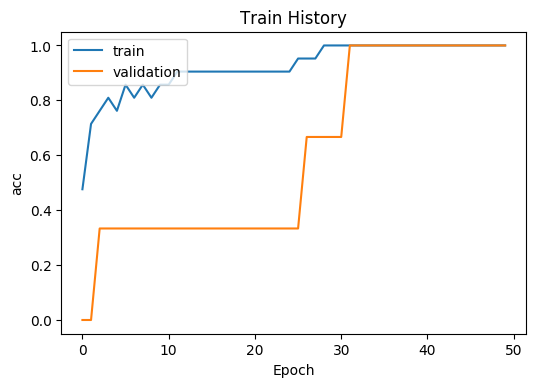

In [314]:
show_train_history(model_history,'acc','val_acc')

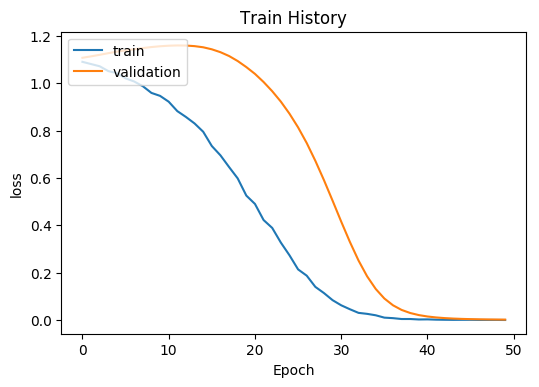

In [315]:
show_train_history(model_history,'loss','val_loss')

In [316]:
def predict(test):

    y_predict = model.predict_classes(test)
    def to_cat_name(x): 
        return mapping[x]

    return to_cat_name(y_predict), y_predict

        
#     print ('input_text : {}'.format(input_text))
#     print ('intent : {}'.format(intent))

def predict_single(input_text):
    pass
#     print ('input_text : {}'.format(input_text))
#     print ('intent : {}'.format(intent))

y_predict_name, y_predict = predict(x_test)

In [317]:
pd.DataFrame({'sentence':df_test.sentence, 'y_predict':y_predict, 'y_predict_name':y_predict_name})

,sentence,y_predict,y_predict_name
0,天氣如何呢?,2,weather
1,今天天氣好熱喔,2,weather
2,明天會下雨嗎?,2,weather
3,查東京到上海的機票,0,air
4,幫我查今天航班資訊,0,air
5,我想查機票,0,air
6,我想訂咖啡,1,coffee
7,拿鐵冰的少冰,0,air
8,中冰拿來一杯,1,coffee


In [318]:
ppp

NameError: name 'ppp' is not defined

In [ ]:
predict('今天天氣')

In [ ]:
predict('我昨天想打電話給周春榮')

In [ ]:
def train(self,epochs=50):
    print 'building model ...'
    self.model = SentimentLSTM.build_model()

    print 'loading data ...'
    (text_train, rate_train), (text_test, rate_text) = self.load_data()

    print 'training model ...'
    self.model.fit(text_train, rate_train,batch_size=1000,epochs=epochs)
    self.model.save('model/keras.model')
    score = self.model.evaluate(text_test,rate_text)
    print score

def load_trained_model(self,path):
    model = SentimentLSTM.build_model()
    model.load_weights(path)
